In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
pd.set_option('display.max_columns', None)
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [2]:
#Importing the data
final_df=pd.DataFrame()
a_df=pd.DataFrame()
b_df=pd.DataFrame()
c_df=pd.DataFrame()

for file_n in os.listdir('listings'):
    if file_n[0]=='.':
        continue
    else:
        add_df = pd.read_csv(f'listings/{file_n}')
        if len(add_df.columns)==106:
            final_df = pd.concat([final_df, add_df], axis=0)
        elif len(add_df.columns)==96:
            a_df = pd.concat([a_df, add_df], axis=0)
        elif len(add_df.columns)==95:
            b_df = pd.concat([b_df, add_df], axis=0)
        else:
            c_df = pd.concat([c_df, add_df], axis=0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



## Combining all 52 datasets, removing columns not present in all

In [3]:
#These are the columns not present in 2018 reports. They will be dropped.
not_in_2018 = ['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
       'minimum_nights_avg_ntm','maximum_nights_avg_ntm', 'number_of_reviews_ltm', 
       'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms', 
       'calculated_host_listings_count_shared_rooms']
sf_df = final_df.drop(columns=not_in_2018)
sf_df = pd.concat([sf_df, a_df], axis=0)

#drop one column not in 2017
sf_df = sf_df.drop(columns=['is_business_travel_ready'])
sf_df = pd.concat([sf_df, b_df], axis=0)

#drop 3 columns not in 2016 & Prior
sf_df = sf_df.drop(columns=['access', 'interaction', 'house_rules'])
sf_df = pd.concat([sf_df, c_df], axis=0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


## Data Cleaning

In [4]:
pd.set_option('display.max_rows', 20)
#Converting Existing Data Columns to Dates
sf_df['last_scraped'] = pd.to_datetime(sf_df['last_scraped'])
sf_df['host_since'] = pd.to_datetime(sf_df['host_since'])
#Adding new date features
sf_df['year'] = sf_df['last_scraped'].transform(lambda x: x.year)
sf_df['month-year'] = sf_df['last_scraped'].transform(lambda x: f'{x.month} {x.year}')
sf_df['month'] = sf_df['last_scraped'].transform(lambda x: x.month)
sf_df['day_of_week'] = sf_df['last_scraped'].transform(lambda x: x.dt.dayofweek)
sf_df['day'] = sf_df['last_scraped'].transform(lambda x: x.day)

#Converting All Price Related Columns from Objects to Floats
sf_df['price'] = sf_df['price'].transform(lambda x: float(x.replace(',', '').replace('$', '')))
sf_df['extra_people'] = sf_df['extra_people'].transform(lambda x: float(x.replace(',', '').replace('$', '')))

#Fill NaNs in fee columns with 0's, because no additional fee, then convert
sf_df[['security_deposit','cleaning_fee']] = sf_df[['security_deposit','cleaning_fee']].fillna(int(0))
sf_df['security_deposit'] = sf_df['security_deposit'].transform(lambda x: 0 if x==int(0) else float(x.replace(',', '').replace('$', '')))
sf_df['cleaning_fee'] = sf_df['cleaning_fee'].transform(lambda x: 0 if x==int(0) else float(x.replace(',', '').replace('$', '')))

#Dropping columns that have over 75% null
over_70_null = sf_df.columns[sf_df.isnull().sum()/len(sf_df) > 0.70]
sf_df = sf_df.drop(columns=over_70_null)

#Removing Outliers (0 & over 2000 daily rate)
outlier_thresh=2000
sf_df = sf_df.loc[~((sf_df['price'] == 0) | (sf_df['price'] > outlier_thresh))]

#Filling the NaNs in beds, bathrooms, bedrooms
#Assume that if the tenant has the full apartment, they have a bathroom/bedroom
cond1= (sf_df['room_type']=='Entire home/apt')
sf_df.loc[cond1 & (sf_df['beds']==0), sf_df.columns=='beds'] = 1
sf_df.loc[cond1 & (sf_df['bathrooms']==0), sf_df.columns=='bathrooms'] = 1
#For the rest, just fill na
sf_df[['beds','bathrooms', 'bedrooms']] = sf_df[['beds','bathrooms', 'bedrooms']].fillna(0)

#For review scores, let's just fillin with the average
review_lst = ['review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_rating', 'review_scores_value']
for review in review_lst:
    sf_df[review] = sf_df[review].fillna(sf_df[review].mean())

## Train Test Split #1: Use 2015 - 2018 to predict 2019 & 2020

In [5]:
test_years=[2020,2019]
train_df = sf_df[~sf_df['year'].isin(test_years)]
test_df = sf_df[sf_df['year'].isin(test_years)]

## Dumb Model: Predicting the average list price for all

In [6]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week']
Xd = train_df[features]
yd = train_df['price']
X_train, X_val, y_train, y_val = train_test_split(Xd, yd, test_size=0.3)

In [7]:
average = np.mean(y_train)
preds_d = np.full(y_val.shape, average)
rmse = np.sqrt(mean_squared_error(preds_d, y_val))
rmse

210.00910038965245

## Baseline Models: No Parameter Tuning or Feature Engineering

In [8]:
baseline_rmse = []
baseline_r2 = []
baseline_adjr2=[]
baseline_rmse2 = []
baseline_r22 = []
baseline_adjr22=[]

In [9]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week']
X = train_df[features]
y = train_df['price'].apply(np.log)

In [10]:
X = pd.get_dummies(X, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [12]:
X_train.isnull().sum().sort_values(ascending=False)

day_of_week_6                          0
property_type_Bed and breakfast        0
neighbourhood_cleansed_Inner Sunset    0
neighbourhood_cleansed_Lakeshore       0
neighbourhood_cleansed_Marina          0
                                      ..
property_type_Loft                     0
property_type_Other                    0
property_type_Pension (Korea)          0
property_type_Plane                    0
accommodates                           0
Length: 121, dtype: int64

In [13]:
estimator = LinearRegression()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(np.exp(preds), np.exp(y_val)))
cs_val = np.mean(cross_val_score(estimator, X, y, cv=5))
baseline_rmse.append(rmse)
baseline_r2.append(np.mean(cs_val))
N = len(X_val)
P = len(X_val.columns)
adj_R2 = 1-((1-r2)*(N-1)/(N-P-1))
baseline_adjr2.append(adj_R2)
print(f'R2: {r2}, Adj R2: {adj_R2}, RMSE: {rmse},\nCross Val Scores: {cs_val}')

R2: 0.6158174574236327, Adj R2: 0.6152528947851612, RMSE: 189.06727684729273,
Cross Val Scores: 0.5862645164899067


In [14]:
estimator = DecisionTreeRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(np.exp(preds), np.exp(y_val)))
cs_val = np.mean(cross_val_score(estimator, X, y, cv=5))
baseline_rmse.append(rmse)
baseline_r2.append(np.mean(cs_val))
N = len(X_val)
P = len(X_val.columns)
adj_R2 = 1-((1-r2)*(N-1)/(N-P-1))
baseline_adjr2.append(adj_R2)
print(f'R2: {r2}, Adj R2: {adj_R2}, RMSE: {rmse},\nCross Val Scores: {cs_val}')

R2: 0.8110877486988183, Adj R2: 0.810810139002347, RMSE: 96.52763748108823,
Cross Val Scores: 0.764475215988065


In [15]:
estimator = RandomForestRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(np.exp(preds), np.exp(y_val)))
cs_val = np.mean(cross_val_score(estimator, X, y, cv=5))
baseline_rmse.append(rmse)
baseline_r2.append(np.mean(cs_val))
N = len(X_val)
P = len(X_val.columns)
adj_R2 = 1-((1-r2)*(N-1)/(N-P-1))
baseline_adjr2.append(adj_R2)
print(f'R2: {r2}, Adj R2: {adj_R2}, RMSE: {rmse},\nCross Val Scores: {cs_val}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.872213155047002, Adj R2: 0.8720253701521841, RMSE: 81.89648086546754,
Cross Val Scores: 0.8445313924339505


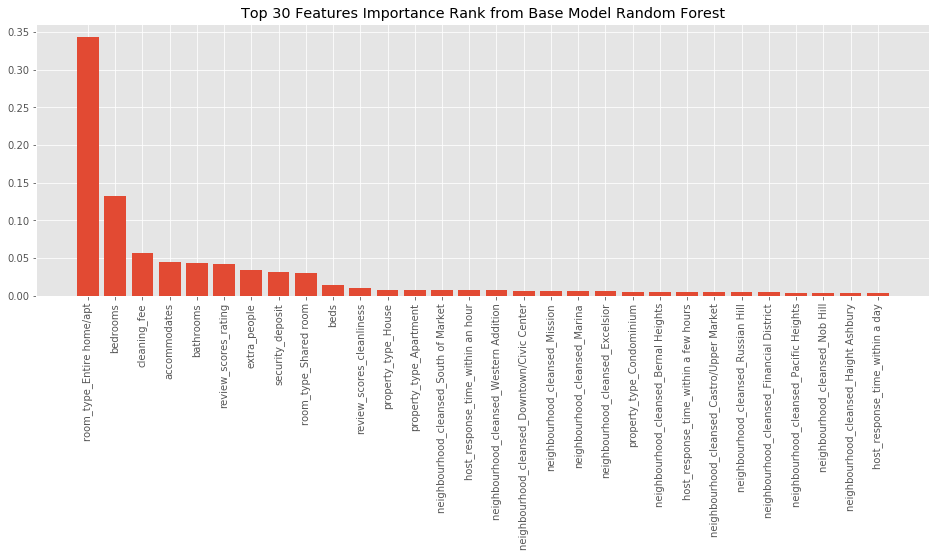

In [16]:
rf_features = X_train.columns
rf_feature_imp = model.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.show()
# plt.savefig('Graphs/Feature_imp_BaseModel_RF.png', dpi = 300)

In [17]:
estimator = GradientBoostingRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(np.exp(preds), np.exp(y_val)))
cs_val = np.mean(cross_val_score(estimator, X, y, cv=5))
baseline_rmse.append(rmse)
baseline_r2.append(np.mean(cs_val))
N = len(X_val)
P = len(X_val.columns)
adj_R2 = 1-((1-r2)*(N-1)/(N-P-1))
baseline_adjr2.append(adj_R2)
print(f'R2: {r2}, Adj R2: {adj_R2}, RMSE: {rmse},\nCross Val Scores: {cs_val}')

R2: 0.6566192824452247, Adj R2: 0.6561146787674967, RMSE: 152.38186563080652,
Cross Val Scores: 0.6511864137991337


## Train Test Split Option 2: Randomized test group

In [18]:
train_df2, test = train_test_split(sf_df, test_size = 0.3, random_state=0)

## Test Dumb Model First

In [19]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week']
Xd = train_df2[features]
yd = train_df2['price'].apply(np.log)
X_train, X_val, y_train, y_val = train_test_split(Xd, yd, test_size=0.3)
average = np.mean(y_train)
preds_d = np.full(y_val.shape, average)
rmse = np.exp(np.sqrt(mean_squared_error(preds_d, y_val)))
rmse

1.997564713767675

In [20]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week']
Xa = train_df2[features]
ya = train_df2['price'].apply(np.log)

Xa = pd.get_dummies(Xa, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

X_train, X_val, y_train, y_val = train_test_split(Xa, ya, test_size=0.3)

In [21]:
N = len(Xa)
P = len(features)-2
adj_R2 = 1-((1-0.88)*(N-1)/(N-P-1))
adj_R2

0.8799939002694048

In [22]:
estimator = LinearRegression()
modela = estimator.fit(X_train,y_train)
preds = modela.predict(X_val)
r2 = modela.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(np.exp(preds), np.exp(y_val)))
cs_val = np.mean(cross_val_score(estimator, Xa, ya, cv=5))
baseline_rmse2.append(rmse)
baseline_r22.append(np.mean(cs_val))
N = len(X_val)
P = len(X_val.columns)
adj_R2 = 1-((1-r2)*(N-1)/(N-P-1))
baseline_adjr22.append(adj_R2)
print(f'R2: {r2}, Adj R2: {adj_R2}, RMSE: {rmse},\nCross Val Scores: {cs_val}')

R2: 0.6088521511707444, Adj R2: 0.6082595460134994, RMSE: 192.59055310105154,
Cross Val Scores: 0.609794417035021


In [23]:
estimator = DecisionTreeRegressor()
modela = estimator.fit(X_train,y_train)
preds = modela.predict(X_val)
r2 = modela.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(np.exp(preds), np.exp(y_val)))
cs_val = np.mean(cross_val_score(estimator, Xa, ya, cv=5))
baseline_rmse2.append(rmse)
baseline_r22.append(np.mean(cs_val))
N = len(X_val)
P = len(X_val.columns)
adj_R2 = 1-((1-r2)*(N-1)/(N-P-1))
baseline_adjr22.append(adj_R2)
print(f'R2: {r2}, Adj R2: {adj_R2}, RMSE: {rmse},\nCross Val Scores: {cs_val}')

R2: 0.8100298755411489, Adj R2: 0.8097420629510663, RMSE: 99.31649245512855,
Cross Val Scores: 0.8197869048419241


In [24]:
estimator = RandomForestRegressor()
modela = estimator.fit(X_train,y_train)
preds = modela.predict(X_val)
r2 = modela.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(np.exp(preds), np.exp(y_val)))
cs_val = np.mean(cross_val_score(estimator, Xa, ya, cv=5))
baseline_rmse2.append(rmse)
baseline_r22.append(np.mean(cs_val))
N = len(X_val)
P = len(X_val.columns)
adj_R2 = 1-((1-r2)*(N-1)/(N-P-1))
baseline_adjr22.append(adj_R2)
print(f'R2: {r2}, Adj R2: {adj_R2}, RMSE: {rmse},\nCross Val Scores: {cs_val}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.8721490235897533, Adj R2: 0.8719553240763691, RMSE: 80.03947259822012,
Cross Val Scores: 0.8810572821113645


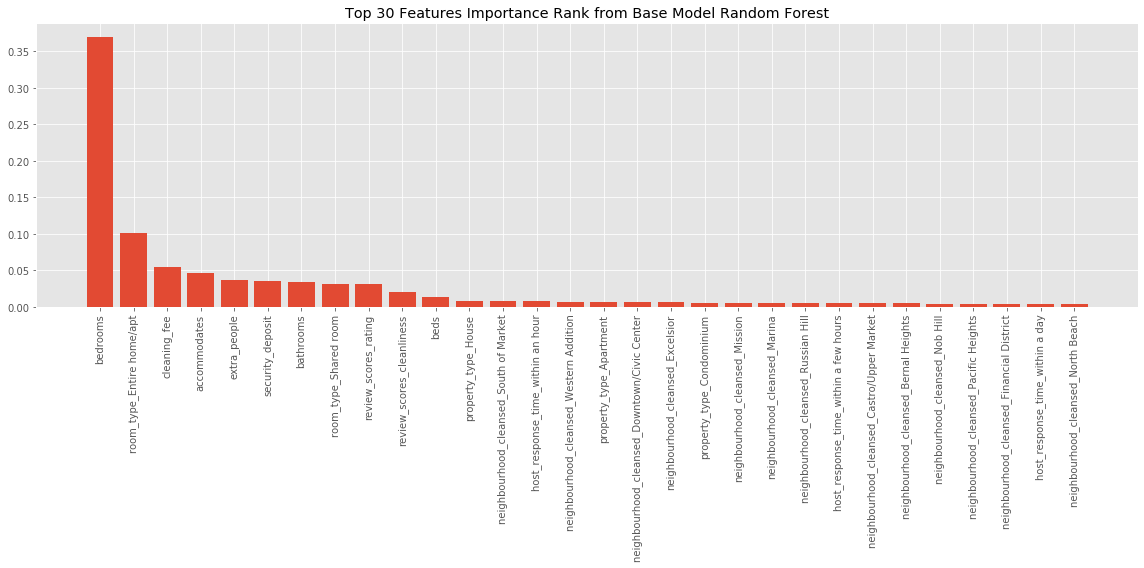

In [25]:
rf_features = X_train.columns
rf_feature_imp = modela.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/Feature_imp_BaseModel_RF.png', dpi = 300)
plt.show()

In [26]:
estimator = GradientBoostingRegressor()
modela = estimator.fit(X_train,y_train)
preds = modela.predict(X_val)
r2 = modela.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(np.exp(preds), np.exp(y_val)))
cs_val = np.mean(cross_val_score(estimator, Xa, ya, cv=5))
baseline_rmse2.append(rmse)
baseline_r22.append(np.mean(cs_val))
N = len(X_val)
P = len(X_val.columns)
adj_R2 = 1-((1-r2)*(N-1)/(N-P-1))
baseline_adjr22.append(adj_R2)
print(f'R2: {r2}, Adj R2: {adj_R2}, RMSE: {rmse},\nCross Val Scores: {cs_val}')

R2: 0.6430745262069169, Adj R2: 0.6425337693622737, RMSE: 148.1036529136087,
Cross Val Scores: 0.6426378979332317


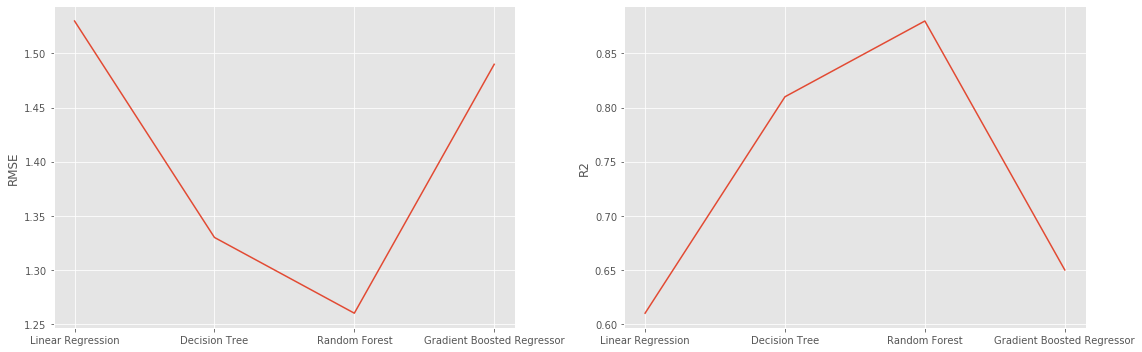

In [27]:
baseline_rmses=[1.53,1.33,1.26,1.49]
baseline_r2=[0.61,0.81,0.88,0.65]

x = np.arange(len(baseline_r22))
x_lab = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosted Regressor']
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(x_lab, baseline_rmses)
ax[0].set_xticks(x_lab)
ax[0].set_ylabel('RMSE')
ax[1].plot(x_lab, baseline_r2)
ax[1].set_xticks(x_lab)
ax[1].set_ylabel('R2')
plt.tight_layout()
# plt.savefig('Graphs/Baseline_Models.png', dpi=300)

## Model Metrics Tracking

In [28]:
train_rmses = []
train_r2s = []
crossval_r2 = []
val_rmses = []
val_r2s = []

## Model Iteration #1: Fee columns (Y or N) with random split

In [29]:
cols = ['has_deposit','has_cleaning_fee','extra_people_fee']

train_df2['has_deposit'] = train_df2['security_deposit'].transform(lambda x: 1 if x>0 else 0)
train_df2['has_cleaning_fee'] = train_df2['cleaning_fee'].transform(lambda x: 1 if x>0 else 0)
train_df2['extra_people_fee'] = train_df2['extra_people'].transform(lambda x: 1 if x>0 else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a 

In [30]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time','neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week', 
          'has_cleaning_fee','has_deposit','extra_people_fee']
X1 = train_df2[features]
y1 = train_df2['price'].apply(np.log)

X1 = pd.get_dummies(X1, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.3)

In [31]:
estimator = RandomForestRegressor()
model1 = estimator.fit(X_train,y_train)
train_preds = model1.predict(X_train)
train_r2 = model1.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

val_preds = model1.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
val_r2 = model1.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X1, y1, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.8746824445091395, Val RMSE: 79.96272103445621,
 Validation Cross Val Score: 0.8719960915781858


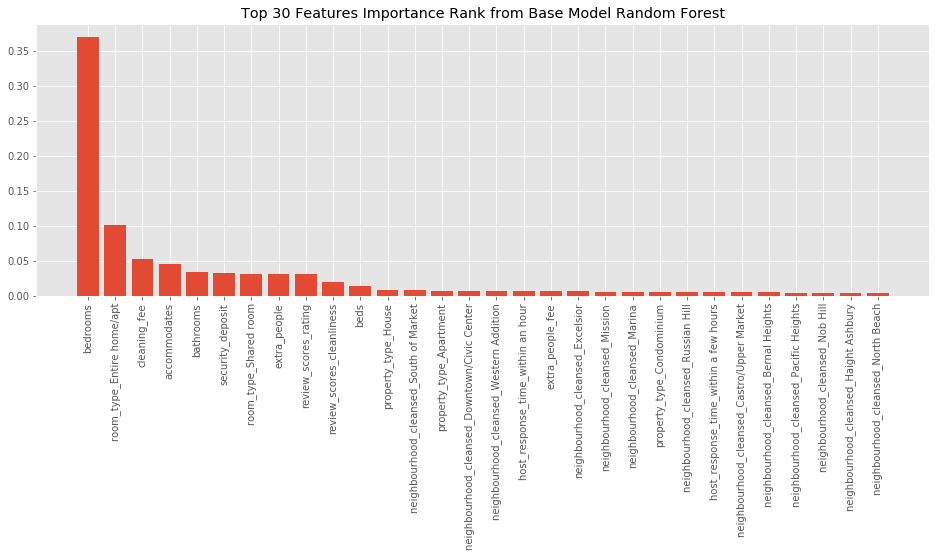

In [32]:
rf_features = X_train.columns
rf_feature_imp = model1.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.show()

In [33]:
#Keep only Y or N column, remove the previous columns
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds', 
          'host_response_time','neighbourhood_cleansed','property_type',
          'review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'month','day_of_week',
          'has_cleaning_fee','has_deposit','extra_people_fee']
X1a = train_df2[features]
y1a = train_df2['price'].apply(np.log)

X1a = pd.get_dummies(X1a, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

X_train, X_val, y_train, y_val = train_test_split(X1a, y1a, test_size=0.3)

In [35]:
estimator = RandomForestRegressor()
model1a = estimator.fit(X_train,y_train)
train_preds = model1a.predict(X_train)
train_r2 = model1a.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

val_preds = model1a.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
val_r2 = model1a.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X1a, y1a, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.8236488114868435, Val RMSE: 92.57088825718405,
 Validation Cross Val Score: 0.8220184604272428


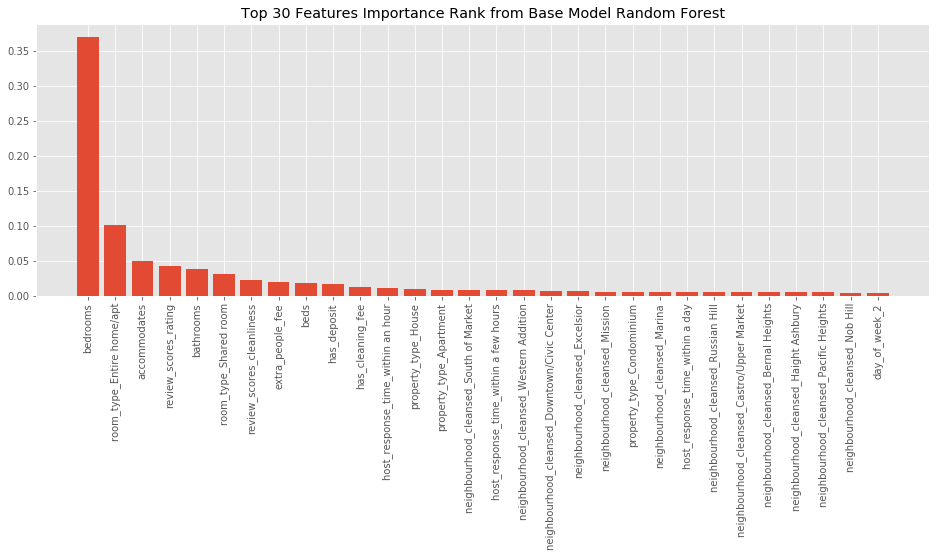

In [36]:
rf_features = X_train.columns
rf_feature_imp = model1a.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.show()

## Model Iteration 2: Count of Amenities, random test/train/split

In [37]:
train_df2['amenities'] = train_df2['amenities'].fillna('0')
train_df2['num_amenities'] = train_df2['amenities'].transform(lambda x: len(x.split(',')))

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month']
X2 = train_df2[features]
y2 = train_df2['price'].apply(np.log)

X2 = pd.get_dummies(X2, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])

X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.3)

In [39]:
estimator = RandomForestRegressor()
model2 = estimator.fit(X_train,y_train)
train_preds = model2.predict(X_train)
train_r2 = model2.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

val_preds = model2.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
val_r2 = model2.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X2, y2, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9053999232399758, Val RMSE: 71.55647001408349,
 Validation Cross Val Score: 0.9044508154709616


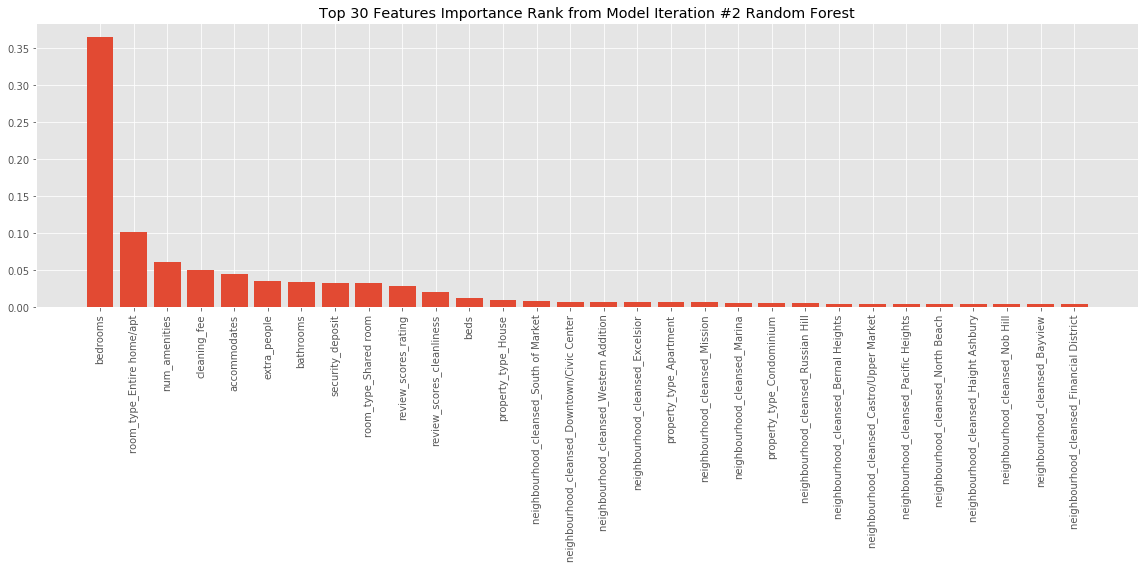

In [40]:
rf_features = X_train.columns
rf_feature_imp = model2.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/num_amenities_imp.png', dpi=300)
plt.show()

## Model Iteration 3: Indicate when property is over a threshold in terms of accommodation features (accomodates, #bedrooms, #bathrooms, #beds)

In [41]:
accom_thresh = 12
bedroom_thresh = 6
bathroom_thresh = 6 #or could be 3?
beds_thresh = 9
train_df2['over_accm'] = train_df2['accommodates'].transform(lambda x: 1 if x>accom_thresh else 0)
train_df2['over_bdrm'] = train_df2['bedrooms'].transform(lambda x: 1 if x>bedroom_thresh else 0)
train_df2['over_btrm'] = train_df2['bathrooms'].transform(lambda x: 1 if x>bathroom_thresh else 0)
train_df2['over_beds'] = train_df2['beds'].transform(lambda x: 1 if x>beds_thresh else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [42]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities', 'over_accm','over_bdrm','over_btrm', 'over_beds',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month']
X3 = train_df2[features]
y3 = train_df2['price'].apply(np.log)

X3 = pd.get_dummies(X3, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])

X_train, X_val, y_train, y_val = train_test_split(X3, y3, test_size=0.3)

In [43]:
estimator = RandomForestRegressor()
model3 = estimator.fit(X_train,y_train)
train_preds = model3.predict(X_train)
train_r2 = model3.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

val_preds = model3.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
val_r2 = model3.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X3, y3, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9050800521510435, Val RMSE: 70.89355179065147,
 Validation Cross Val Score: 0.9046930661195177


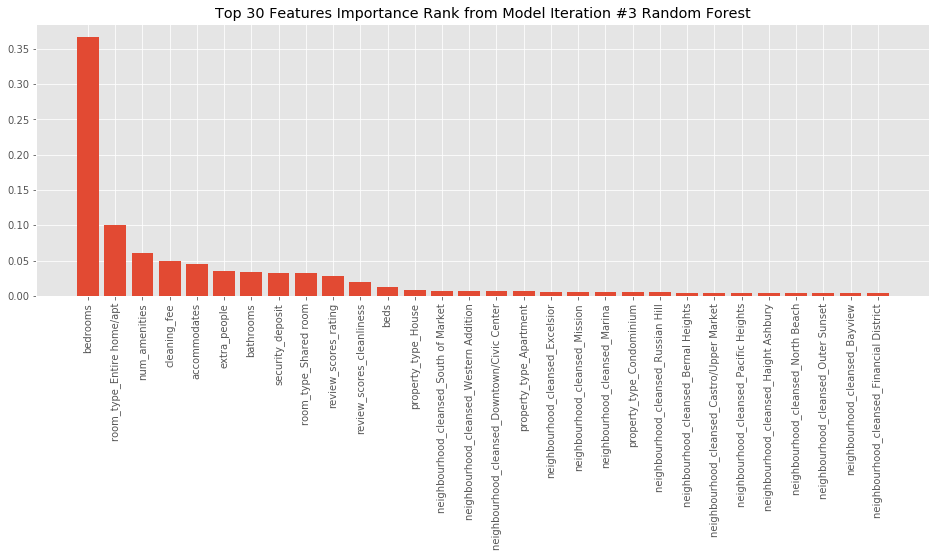

In [44]:
rf_features = X_train.columns
rf_feature_imp = model3.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #3 Random Forest')
plt.show()

## Model Iteration 4: Regions

In [45]:
Northeast = ["Mission", "Western Addition", "South Of Market", "Castro/Upper Market,"
             "Downtown/Civic Center", "Haight Ashbury", "Nob Hill", "Marina", "Pacific Heights",
            "Russian Hill", "North Beach", "Financial District", "Chinatown", "Presidio Heights"]
Southeast = ["Bernal Heights", "Noe Valley", "Potrero Hill", "Excelsior", "Bayview", "Glen Park", 
             "Visitacion Valley," "Crocker Amazon", "Diamond Heights"]
Northwest = ["Inner Richmond", "Outer Sunset", "Outer Richmond", "Inner Sunset", "Twin Peaks", 
             "Seacliff", "Golden Gate Park", "Presidio"]
Southwest = ["Outer Mission", "Parkside", "West of Twin Peaks", "Ocean View", "Lakeshore"]
Other = ["Treasure Island/YBI"]

def region(x):
    if x in Northeast:
        return 'Northeast'
    elif x in Southeast:
        return 'Southeast'
    elif x in Northwest:
        return "Northwest"
    elif x in Southwest:
        return "Southwest"
    else:
        return "Other"
train_df2['Region'] = train_df2['neighbourhood_cleansed'].apply(region)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities',
         'Region','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month']
X4 = train_df2[features]
y4 = train_df2['price'].apply(np.log)

X4 = pd.get_dummies(X4, columns=['bed_type','Region','property_type',
                           'room_type','month'])

X_train, X_val, y_train, y_val = train_test_split(X4, y4, test_size=0.3)

In [47]:
estimator = RandomForestRegressor()
model4 = estimator.fit(X_train,y_train)
train_preds = model4.predict(X_train)
train_r2 = model4.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

val_preds = model4.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
val_r2 = model4.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X4, y4, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.88398425982303, Val RMSE: 76.21537969843598,
 Validation Cross Val Score: 0.8817520156163415


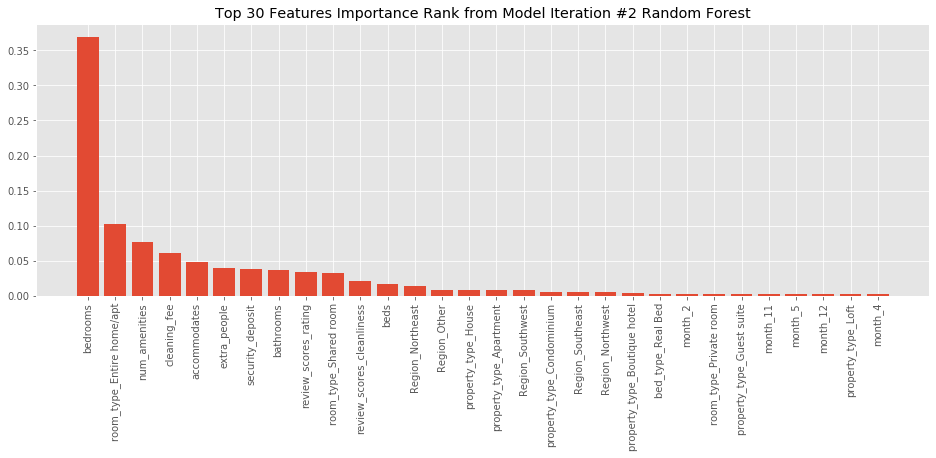

In [48]:
rf_features = X_train.columns
rf_feature_imp = model4.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.show()

## Iteration 5: Downtown or not

In [49]:
downtown = ["Western Addition", "South Of Market", "Downtown/Civic Center", 
                    "Financial District"]
train_df2['Downtown'] = train_df2['neighbourhood_cleansed'].transform(lambda x: 1 if x in downtown else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month',
         'Downtown']
X5 = train_df2[features]
y5 = train_df2['price'].apply(np.log)

X5 = pd.get_dummies(X5, columns=['bed_type','property_type',
                           'room_type','month'])

X_train, X_val, y_train, y_val = train_test_split(X5, y5, test_size=0.3)

In [51]:
estimator = RandomForestRegressor()
model5 = estimator.fit(X_train,y_train)
train_preds = model5.predict(X_train)
train_r2 = model5.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

val_preds = model5.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
val_r2 = model5.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X5, y5, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.8677715694659514, Val RMSE: 81.16877715064331,
 Validation Cross Val Score: 0.8660900256638885


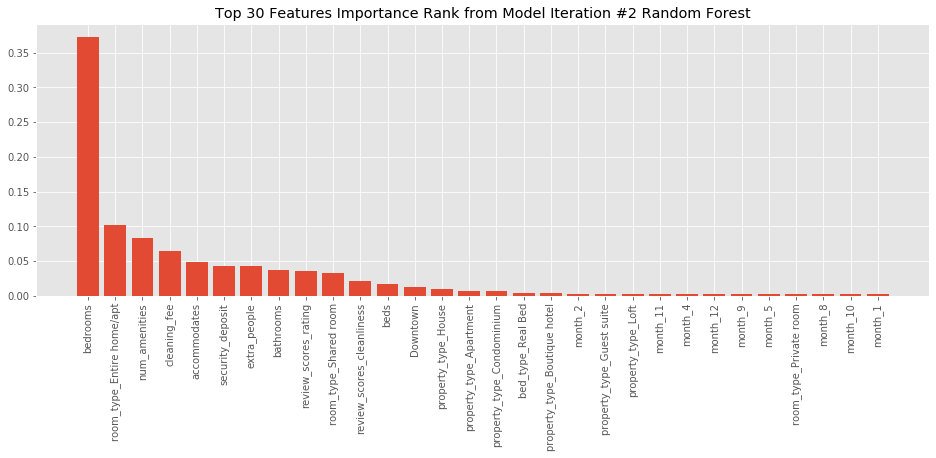

In [52]:
rf_features = X_train.columns
rf_feature_imp = model5.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.show()

## Iteration 6: Apartment or Shared Room, Property Type: House Only

In [53]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month']
X6 = train_df2[features]
y6 = train_df2['price'].apply(np.log)

X6 = pd.get_dummies(X6, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])

In [54]:
X6 = X6.drop(columns=['room_type_Hotel room', 'room_type_Private room'])

In [55]:
X6.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
       'extra_people', 'num_amenities', 'review_scores_cleanliness',
       'review_scores_rating', 'security_deposit',
       ...
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object', length=113)

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X6, y6, test_size=0.3)

In [57]:
estimator = RandomForestRegressor()
model6 = estimator.fit(X_train,y_train)
train_preds = model6.predict(X_train)
train_r2 = model6.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

val_preds = model6.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
val_r2 = model6.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X6, y6, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.904793367751506, Val RMSE: 70.02436899059006,
 Validation Cross Val Score: 0.9038793371046333


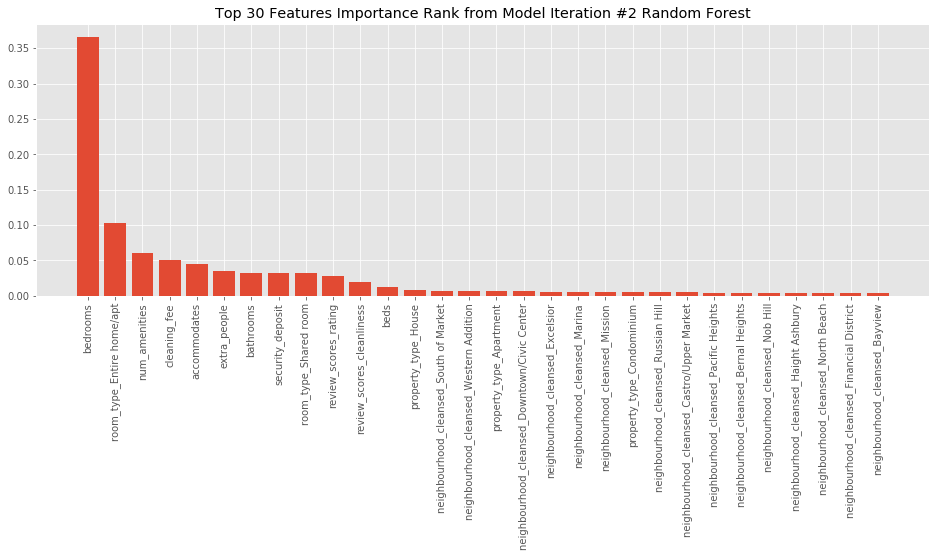

In [58]:
rf_features = X_train.columns
rf_feature_imp = model6.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.show()

In [62]:
#Remove all property types but house
X6a = X6.drop(columns=['property_type_Aparthotel',
       'property_type_Barn', 'property_type_Bed & Breakfast',
       'property_type_Bed and breakfast', 'property_type_Boat',
       'property_type_Boutique hotel', 'property_type_Bungalow',
       'property_type_Bus', 'property_type_Cabin', 'property_type_Camper/RV',
       'property_type_Casa particular', 'property_type_Castle',
       'property_type_Cave', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Cottage',
       'property_type_Cycladic house (Greece)', 'property_type_Dome house',
       'property_type_Dorm', 'property_type_Earth House',
       'property_type_Earth house', 'property_type_Entire Floor', 'property_type_Floor',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_Hotel',
       'property_type_Hut', 'property_type_In-law', 'property_type_Island',
       'property_type_Lighthouse', 'property_type_Loft', 'property_type_Other',
       'property_type_Pension (Korea)', 
       'property_type_Resort', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Timeshare',
       'property_type_Tiny house', 'property_type_Yurt',
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Vacation home', 'property_type_Villa','property_type_Tipi'])
not_in_axis = ['property_type_Farm stay', 'property_type_Plane',]

In [63]:
X_train, X_val, y_train, y_val = train_test_split(X6a, y6, test_size=0.3)

In [69]:
estimator = RandomForestRegressor()
model6a = estimator.fit(X_train,y_train)
train_preds = model6a.predict(X_train)
train_r2 = model6a.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

val_preds = model6a.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
val_r2 = model6a.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X6a, y6, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9033333938538441, Val RMSE: 73.38955258120393,
 Validation Cross Val Score: 0.9018134796652927


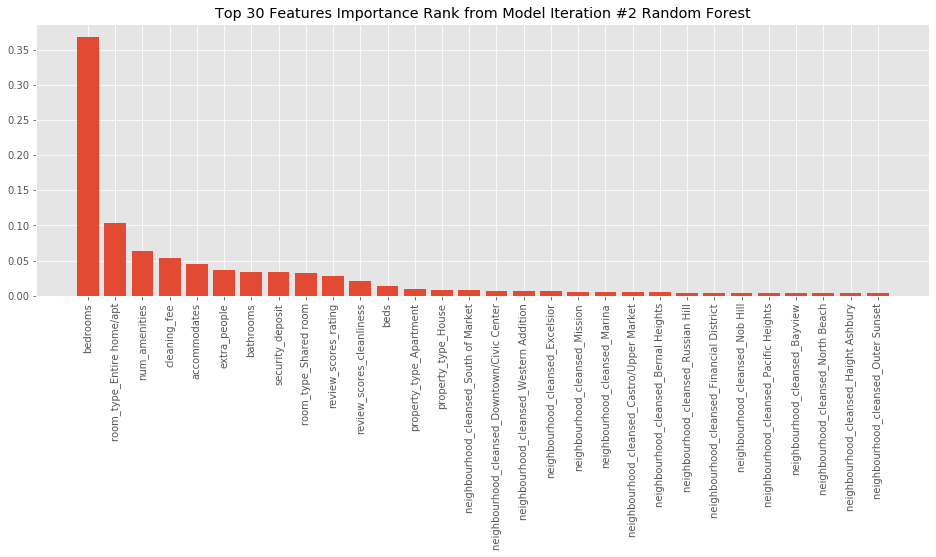

In [70]:
rf_features = X_train.columns
rf_feature_imp = model6a.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.show()

## Iteration 7: Adding Text Lengths

In [71]:
train_df2[['space','summary','description','name']] = train_df2[['space','summary','description','name']].fillna('0')
train_df2['len_space'] = train_df2['space'].transform(lambda x: 0 if x=='0' else len(x))
train_df2['len_summary'] = train_df2['summary'].transform(lambda x: 0 if x=='0' else len(x))
train_df2['len_description'] = train_df2['description'].transform(lambda x: 0 if x=='0' else len(x))
train_df2['len_name'] = train_df2['name'].transform(lambda x: 0 if x=='0' else len(x))

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [72]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed','property_type',
          'review_scores_cleanliness','len_space', 'len_summary', 'len_description',
          'len_name', 'review_scores_rating', 'room_type', 'security_deposit', 'month']
X7 = train_df2[features]
y7 = train_df2['price'].apply(np.log)

X7 = pd.get_dummies(X7, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])

In [73]:
X_train, X_val, y_train, y_val = train_test_split(X7, y7, test_size=0.3)

In [74]:
estimator = RandomForestRegressor()
model7 = estimator.fit(X_train,y_train)
train_preds = model7.predict(X_train)
train_r2 = model7.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

val_preds = model7.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
val_r2 = model7.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X7, y7, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9296565814352725, Val RMSE: 61.29095598649543,
 Validation Cross Val Score: 0.9280857574670388


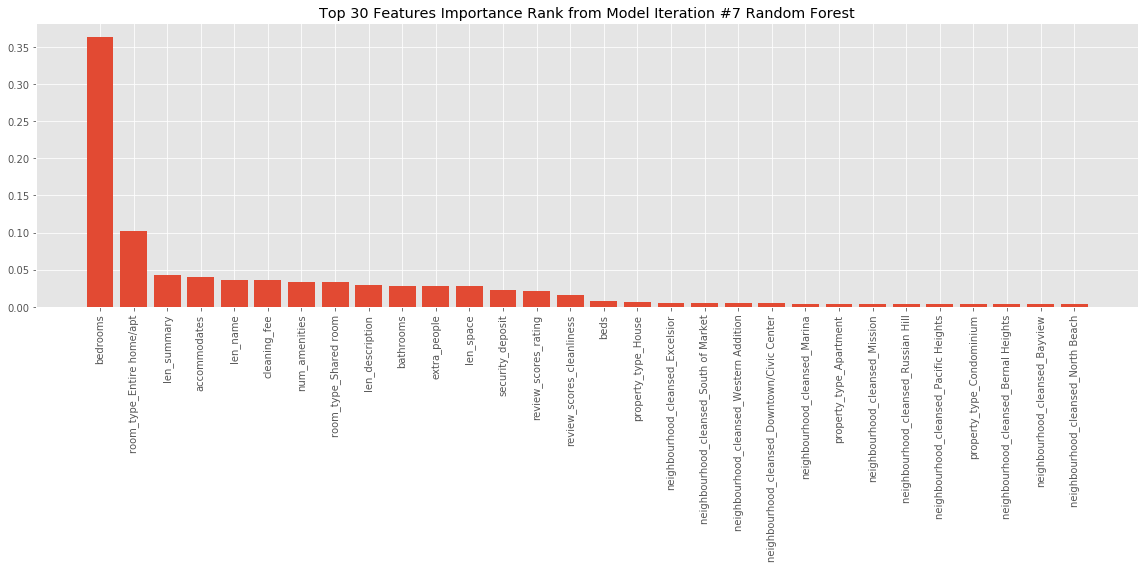

In [75]:
rf_features = X_train.columns
rf_feature_imp = model7.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #7 Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/Length_text_feat_imp.png', dpi=300)
plt.show()

## Model iteration 8: Feature engineer to capture "Entire House/Apartment", "Shared room", "Property-Type:House", & "Property Type: Aprtment" to reduce model complexity

In [76]:
train_df2['House'] = train_df2['property_type'].transform(lambda x: 1 if x=='Apartment' else 0)
train_df2['Apartment'] = train_df2['property_type'].transform(lambda x: 1 if x=='House' else 0)
train_df2['Entire_Space'] = train_df2['room_type'].transform(lambda x: 1 if x=='Entire home/apt' else 0)
train_df2['Shared_room'] = train_df2['room_type'].transform(lambda x: 1 if x=='Shared room' else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [77]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed',
          'review_scores_cleanliness','len_space', 'len_summary', 'len_description',
          'len_name', 'review_scores_rating', 'security_deposit', 'month', 
          'House', 'Apartment', 'Entire_Space','Shared_room']
X8 = train_df2[features]
y8 = train_df2['price'].apply(np.log)

X8 = pd.get_dummies(X8, columns=['bed_type','neighbourhood_cleansed','month'])

In [78]:
X_train, X_val, y_train, y_val = train_test_split(X8, y8, test_size=0.3, random_state=0)

In [79]:
estimator = RandomForestRegressor()
model8 = estimator.fit(X_train,y_train)
train_preds = model8.predict(X_train)
train_r2 = model8.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

val_preds = model8.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
val_r2 = model8.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X8, y8, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9308584177172193, Val RMSE: 61.83266796820938,
 Validation Cross Val Score: 0.9265955898649935


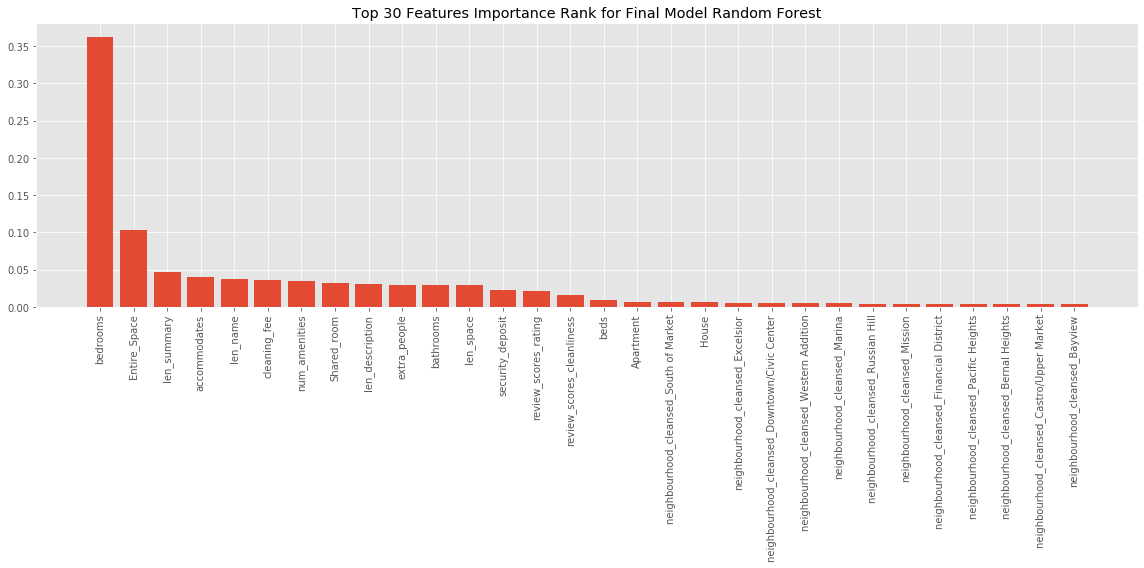

In [80]:
rf_features = X_train.columns
rf_feature_imp = model8.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank for Final Model Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/Final_model_feat_imp.png', dpi=300)
plt.show()

In [ ]:
X_train.columns

**According to GridSearchCV, best hyperparameters are n_estimators=400 & max_features = 20**

In [185]:
#400 est & 20 max_feats = RMSE: 59.33
estimator = RandomForestRegressor(max_features=40, n_estimators=200)
model9 = estimator.fit(X_train,y_train)
preds = model9.predict(X_val)
r2 = model9.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(np.exp(preds), np.exp(y_val)))
print(r2,rmse)

0.942749619864331 58.55657438566323


## More existing features

In [167]:
train_df2[["availability_30","availability_365","availability_60","availability_90"]] = train_df2[["availability_30","availability_365","availability_60","availability_90"]].fillna(0)
train_df2[['number_of_reviews', "review_scores_accuracy",
          "review_scores_checkin", "review_scores_cleanliness",
          "review_scores_communication","review_scores_location",
          "review_scores_rating", "review_scores_value",
          "reviews_per_month"]] = train_df2[['number_of_reviews', "review_scores_accuracy",
          "review_scores_checkin", "review_scores_cleanliness",
          "review_scores_communication","review_scores_location",
          "review_scores_rating", "review_scores_value",
          "reviews_per_month"]].fillna(0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [168]:
#NOTE TO SELF: NOTHING WORKED BUT AVAIL 60, TRIED ALL OTHER FEATURES
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed',
          'review_scores_cleanliness','len_space', 'len_summary', 'len_description',
          'len_name', 'review_scores_rating', 'security_deposit', 'month', 
          'House', 'Apartment', 'Entire_Space','Shared_room', "availability_60"]
X10 = train_df2[features]
y10 = train_df2['price'].apply(np.log)

X10 = pd.get_dummies(X10, columns=['bed_type','neighbourhood_cleansed','month'])

In [169]:
estimator = RandomForestRegressor()
model10 = estimator.fit(X_train,y_train)
train_preds = model10.predict(X_train)
train_r2 = model10.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

val_preds = model10.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
val_r2 = model10.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X10, y10, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.93118231648946, Val RMSE: 61.79242614148734,
 Validation Cross Val Score: 0.9194249647662511


In [ ]:
rf_features = X_train.columns
rf_feature_imp = model10.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #7 Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/Length_text_feat_imp.png', dpi=300)
plt.show()

## Comparing Model Iterations

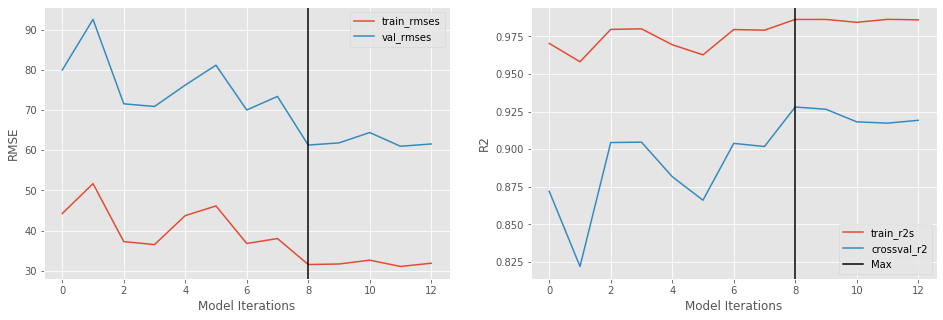

In [172]:
x = np.arange(len(train_r2s))
metric_names=['train_rmses', 'val_rmses', 'train_r2s', 'crossval_r2', 'val_r2s']
metric_lst=[train_rmses, val_rmses, train_r2s, np.mean(crossval_r2, axis=1), val_r2s]

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(x, metric_lst[0], label=f'{metric_names[0]}')
ax[0].plot(x, metric_lst[1], label=f'{metric_names[1]}')
ax[0].set_xlabel('Model Iterations')
ax[0].set_ylabel('RMSE')
ax[0].legend()
ax[0].axvline(8,color='black', label='Min')
ax[1].plot(x, metric_lst[2], label=f'{metric_names[2]}')
ax[1].plot(x, metric_lst[3], label=f'{metric_names[3]}')
ax[1].axvline(8,color='black', label='Max')
# ax[1].plot(x, metric_lst[4], label=f'{metric_names[4]}')
ax[1].set_xlabel('Model Iterations')
ax[1].set_ylabel('R2')
ax[1].legend()
# plt.savefig('Graphs/Metrics_over_iterations.png',dpi=300)

In [ ]:
len(X_train)*.01

## Model Tuning on Iteration 10

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [174]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed',
          'review_scores_cleanliness','len_space', 'len_summary', 'len_description',
          'len_name', 'review_scores_rating', 'security_deposit', 'month', 
          'House', 'Apartment', 'Entire_Space','Shared_room', "availability_60"]
X11 = train_df2[features]
y11 = train_df2['price'].apply(np.log)

X11 = pd.get_dummies(X11, columns=['bed_type','neighbourhood_cleansed','month'])

In [179]:
train_r2s_tune = {}
train_rmses_tune = {}
val_r2s_tune = {}
val_rmses_tune = {}
crossval_r2_tune = {}

In [180]:
n_ests = [200,400,600,800]
for num in n_ests:
    estimator = RandomForestRegressor(n_estimators=num)
    model10 = estimator.fit(X_train,y_train)
    train_preds = model10.predict(X_train)
    train_r2 = model10.score(X_train, y_train)
    train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

    val_preds = model10.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
    val_r2 = model10.score(X_val, y_val)

    cs_val2 = cross_val_score(estimator, X10, y10, cv=3)

    train_rmses_tune[f'n_est {num}'] = train_rmse
    train_r2s_tune[f'n_est {num}'] = train_r2
    crossval_r2_tune[f'n_est {num}'] = cs_val2
    val_rmses_tune[f'n_est {num}'] = val_rmse
    val_r2s_tune[f'n_est {num}']= val_r2
    print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

Val R2: 0.9401020727990892, Val RMSE: 58.7603821287842,
 Validation Cross Val Score: 0.9305565534884948
Val R2: 0.940006938395559, Val RMSE: 58.90561180109416,
 Validation Cross Val Score: 0.9307997757566362
Val R2: 0.9402094307618029, Val RMSE: 58.84796942975578,
 Validation Cross Val Score: 0.9308655263571254


KeyboardInterrupt: 

In [181]:
max_feats = [20,40,60,70]
for num in max_feats:
    estimator = RandomForestRegressor(max_features=num)
    model10 = estimator.fit(X_train,y_train)
    train_preds = model10.predict(X_train)
    train_r2 = model10.score(X_train, y_train)
    train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

    val_preds = model10.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
    val_r2 = model10.score(X_val, y_val)

    cs_val2 = cross_val_score(estimator, X10, y10, cv=3)

    train_rmses_tune[f'max_feats {num}'] = train_rmse
    train_r2s_tune[f'max_feats {num}'] = train_r2
    crossval_r2_tune[f'max_feats {num}'] = cs_val2
    val_rmses_tune[f'max_feats {num}'] = val_rmse
    val_r2s_tune[f'max_feats {num}']= val_r2
    print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9323677760215149, Val RMSE: 61.71307542240604,
 Validation Cross Val Score: 0.919050947804625


/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9333025092541478, Val RMSE: 60.456747974056,
 Validation Cross Val Score: 0.9213766696246345


/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.932966473639623, Val RMSE: 60.83944966399172,
 Validation Cross Val Score: 0.9214892085469303


/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9319358687531607, Val RMSE: 61.23103841801902,
 Validation Cross Val Score: 0.920544401551813


In [182]:
max_depth = [0.2,0.4,0.6,0.8]
for num in max_depth:
    estimator = RandomForestRegressor(max_depth=num*len(X_train))
    model10 = estimator.fit(X_train,y_train)
    train_preds = model10.predict(X_train)
    train_r2 = model10.score(X_train, y_train)
    train_rmse = np.sqrt(mean_squared_error(np.exp(train_preds), np.exp(y_train)))

    val_preds = model10.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(np.exp(val_preds), np.exp(y_val)))
    val_r2 = model10.score(X_val, y_val)

    cs_val2 = cross_val_score(estimator, X10, y10, cv=3)

    train_rmses_tune[f'max_depth {num}'] = train_rmse
    train_r2s_tune[f'max_depth {num}'] = train_r2
    crossval_r2_tune[f'max_depth {num}'] = cs_val2
    val_rmses_tune[f'max_depth {num}'] = val_rmse
    val_r2s_tune[f'max_depth {num}']= val_r2
    print(f'Val R2: {val_r2}, Val RMSE: {val_rmse},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9304074322193631, Val RMSE: 61.43006895033232,
 Validation Cross Val Score: 0.9192027719913917


/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9302100501172902, Val RMSE: 61.919960144268856,
 Validation Cross Val Score: 0.919619698760784


/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9310862269152509, Val RMSE: 61.69842079249699,
 Validation Cross Val Score: 0.9197338857346402


/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9299230630610692, Val RMSE: 62.57918358791479,
 Validation Cross Val Score: 0.9185555866436669


## Performance on Test Data

In [183]:
#Use on Test Data
#Adding in all feature engineering for best performing model with Random Forest
test['amenities'] = test['amenities'].fillna('0')
test['num_amenities'] = test['amenities'].transform(lambda x: len(x.split(',')))
test[['space','summary','description','name']] = test[['space','summary','description','name']].fillna('0')
test['len_space'] = test['space'].transform(lambda x: 0 if x=='0' else len(x))
test['len_summary'] = test['summary'].transform(lambda x: 0 if x=='0' else len(x))
test['len_description'] = test['description'].transform(lambda x: '0' if x==0 else len(x))
test['len_name'] = test['name'].transform(lambda x: 0 if x=='0' else len(x))
test['House'] = test['property_type'].transform(lambda x: 1 if x=='Apartment' else 0)
test['Apartment'] = test['property_type'].transform(lambda x: 1 if x=='House' else 0)
test['Entire_Space'] = test['room_type'].transform(lambda x: 1 if x=='Entire home/apt' else 0)
test['Shared_room'] = test['room_type'].transform(lambda x: 1 if x=='Shared room' else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on 

In [184]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed',
          'review_scores_cleanliness','len_space', 'len_summary', 'len_description',
          'len_name', 'review_scores_rating', 'security_deposit', 'month', 
          'House', 'Apartment', 'Entire_Space','Shared_room']
X_test = test[features]
y_test = test['price'].apply(np.log)

X_test = pd.get_dummies(X_test, columns=['bed_type','neighbourhood_cleansed','month'])

In [93]:
preds = model8.predict(X_test)
r2 = model8.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(np.exp(preds), np.exp(y_test)))
print(r2,rmse)

0.9322074072172173 58.98103417491714


In [186]:
preds = model9.predict(X_test)
r2 = model9.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(np.exp(preds), np.exp(y_test)))
print(r2,rmse)

0.9430420226668212 55.849464694363384


In [95]:
results = pd.DataFrame([np.exp(preds),np.exp(y_test)], index=['preds','y_test'])
results = results.T

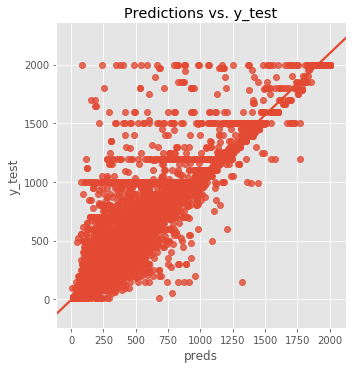

In [96]:
sns.lmplot(data=results, x="preds",y="y_test")
plt.title('Predictions vs. y_test')
plt.savefig('Graphs/preds_vs_ytest.png', dpi=300)

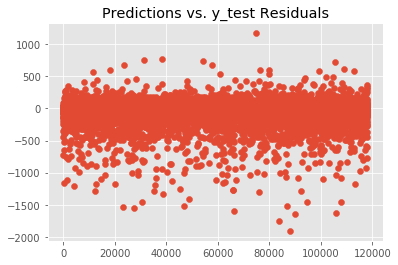

In [97]:
resids = np.exp(preds)-np.exp(y_test)
plt.scatter(np.arange(len(resids)), resids)
plt.title('Predictions vs. y_test Residuals')
plt.savefig('Graphs/residuals.png', dpi=300)

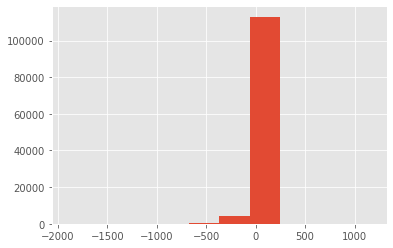

In [98]:
resids.hist()

In [99]:
N = len(test)
P = 22
adj_R2 = 1-((1-0.94)*(N-1)/(N-P-1))

In [100]:
adj_R2

0.9399888156445408